# import

In [14]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

In [15]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# functions

In [16]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [17]:
def RegsToTups(all_regs):
    alledges=[]
    allnodes=[]
    for arr in all_regs:
        list0=arr[0]
        list1=arr[1]
        for i in range(len(list0)):
            qubit0=int(list0[i])
            qubit1=int(list1[i])
            alledges.append((qubit0,qubit1))
            allnodes.append(qubit0)
            allnodes.append(qubit1)
    allnodes=set(allnodes)
    return alledges,allnodes

# Embedding of a single plaquette term - even parity

this method uses two basic plaquettes of the Zephyr lattice. We found later that this can be done with one plaquette only. That's the embedding in the Lechner paper.

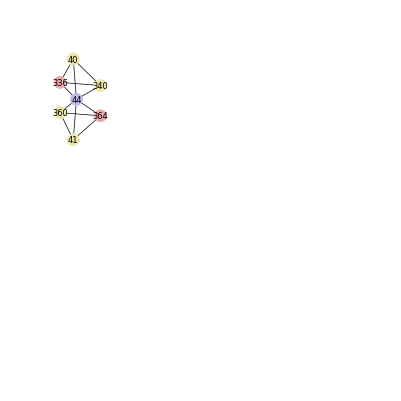

In [71]:
ancillas = {336, 364}
plaquette = {44}
qubits = {40, 340, 360, 41}
alledges_non_filter = [(40, 340), (40, 336), (40, 44), (336, 340), (336, 44), (340, 44), (44, 41), (44, 360), (44, 364), (360, 364), (360, 41), (364, 41)]
alledges = []
for edge in alledges_non_filter:
    if edge in sampler.edgelist:
        alledges.append(edge)
    elif Reverse(edge) in sampler.edgelist:
        alledges.append(Reverse(edge))

qubits=list(set(qubits))
#allnodes = list(set(allnodes))
ancillas=list(set(ancillas))
plaquette=list(set(plaquette))
allnodes = ancillas + qubits + plaquette


plt.ion()
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["figure.dpi"]=50

alllabels={}
for node in allnodes:
    alllabels.update({node:str(node)})

graph_all=dnx.zephyr_graph(4,edge_list=alledges)

allcolors=[]
for node in graph_all.nodes():
    if (node in qubits):
        allcolors.append('#ede6a8')
    elif (node in ancillas):
        allcolors.append('#eda8a8')
    elif (node in plaquette):
        allcolors.append('#c1b4ed')
    else:
        allcolors.append('none')

# allcolors=np.array([sorted(allnodes),allcolors])
    
dnx.draw_zephyr(
    graph_all,
    node_color=allcolors,
    labels=alllabels,
)
# dnx.draw_zephyr(Zeph)
# dnx.draw_zephyr(Kag1,node_color='#eda8a8',with_labels=True)
# dnx.draw_zephyr(Kag2,node_color='b',with_labels=True)
# dnx.draw_zephyr(Kag2andcon,node_color='#83ebe0',with_labels=True)
# plt.savefig('folded_kagome')
plt.show()

create the h dict and the J dict - By Hand!

In [72]:
h_dict = {}
for i in graph_all.nodes:
    if i in ancillas:
        h_dict.update({i:-2})
    elif i in plaquette:
        h_dict.update({i:-2})
    elif i in qubits:
        h_dict.update({i:-1})

J_dict = {}
for e in graph_all.edges:
    if e[0] in ancillas or e[1] in ancillas:
        J_dict.update({e:2})
    else:
        J_dict.update({e:1})

inspector to show the embedding and the results. A very few number of reads (100) and annealing time of 20 us is enough. Spin reversal transforms are useful to then be able to observe the 8 degenerate states with equal (even) parity:

++++,
++--,
+--+,
--++,
-++-,
-+-+,
+-+-,----

In [73]:


response = sampler.sample_ising(h = h_dict, J=J_dict,
                                            num_reads=100,
                                            annealing_time=20,
                                            answer_mode="raw", num_spin_reversal_transforms = 5)
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=791b24ca-e9fe-4892-bb81-be61959a951a

'http://127.0.0.1:18000/?problemId=791b24ca-e9fe-4892-bb81-be61959a951a'

explicitly measuring the parity. first - obtain the index of the qubits forming the plaquette

In [74]:
#the index of the plaquette qubit
ind_plaquette = response.variables.index(44) #this is the center of the plaquette - but its value is *not* equal to the parity
inds_qb_plaquettes = []
for j in qubits:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
plaq_values_compare = []
for resp in response.record:
    plaq_values.append(resp[0][ind_plaquette])
    plaq_values_compare.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values


In [75]:
#count the number of times constraint is off. 
coff = 0
for i in range(100):
    if plaq_values[i] != plaq_values_compare[i]:
        coff += 1

print(coff/100)

0.33


6 % of iterations lead to the wrong plaquette value

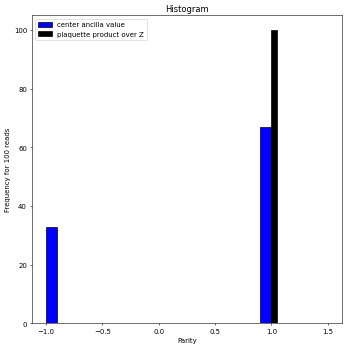

In [76]:
import matplotlib.pyplot as plt
# Create histogram
num_vals = len(plaq_values)
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'center ancilla value')
plt.hist(np.array(plaq_values_compare), bins=20, edgecolor='black', color = 'black', label = 'plaquette product over Z')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 100 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()


The plaquette is always found in the even state (P = 1). This then works well, and 7 qubits are requires (4 logical and 3 ancilla)

This embedding was then tried to be made into a P=-1 odd embedding - but it did not work. Another embedding route is needed.

# Minor embedding of a odd parity gadget

First, practice embedding

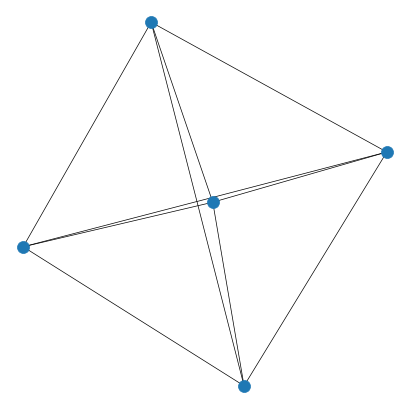

In [52]:
import networkx as nx
import dwave_networkx as dnx
import minorminer.layout as mml
from minorminer import find_embedding

#a simple test graph
#grid_graph = nx.generators.lattice.grid_2d_graph(3, 3)
test_graph = [(1,2), (1,3), (1,4), (1,0), (2,3), (2,4), (2,0), (3,4), (3,0), (4,0)]
#show the embedding graph
G=nx.from_edgelist(test_graph)
nx.draw(G)

{1: [51, 520], 2: [3], 3: [512], 4: [7], 0: [23, 528]}


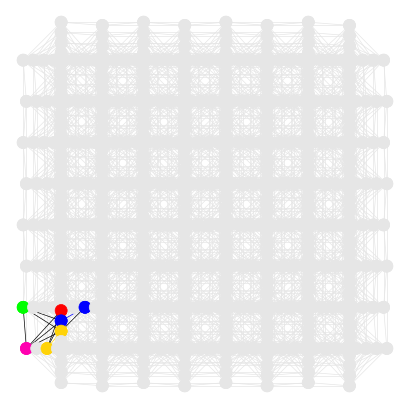

In [53]:
#emebedding into zephyr
C = dnx.zephyr_graph(4)

embedding = mml.find_embedding(test_graph, C)
print(embedding)

#show it in the zephy graph
dnx.draw_zephyr_embedding(C, embedding)


# test odd parity encoding

This is the Lechner et al embedding. First attempt is on two unit cells of the Zephyr graph. It requires no magnetic field

In [77]:
edges_chain = [(42, 448), (62, 468), (38, 488), (43, 508)]
edges_dominant = [(488, 46), (43, 46), (42, 46), (468, 46)]
edges_intra = [(38, 448), (42, 43), (42, 468), (488, 62), (488, 43), (62, 508)]

all_edges = edges_chain + edges_dominant + edges_intra
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -4
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

In [79]:
num_reads = 100
response = sampler.sample_ising(h = {}, J=J_dict,
                                            num_reads=num_reads,
                                            annealing_time=20,
                                            answer_mode="raw", num_spin_reversal_transforms = 10)

In [80]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=0b03402b-69a4-4c28-b80e-c322c68a7fa7

'http://127.0.0.1:18000/?problemId=0b03402b-69a4-4c28-b80e-c322c68a7fa7'

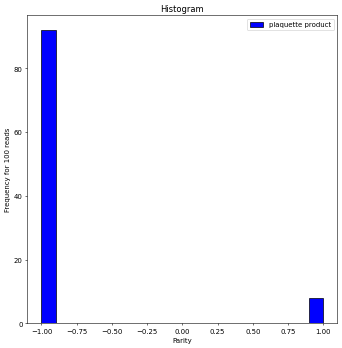

In [84]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
qubits_measure =  [42, 62, 38,43] #majority rule
for j in qubits_measure:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 100 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



another version: more succint. Relies on a single 4-chain as an ancilla, and everything can be done on a unit cell of the Zephyr graph

In [85]:
edges_chain = [(51, 532), (55, 532), (528, 55), (528, 51)]
edges_dominant = [(43, 532), (43, 528),(51, 520), (51, 524), (47, 528), (47, 532), (55, 520), (55,524)]
edges_intra = [(43,520), (43,524), (520,47), (524, 47)]
edges_diagonal = [(43, 47), (520,524)]

all_edges = edges_chain + edges_dominant + edges_intra + edges_diagonal
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_diagonal:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

In [86]:
num_reads = 200
response = sampler.sample_ising(h = {}, J=J_dict,
                                            num_reads=num_reads,
                                            annealing_time=100,
                                            answer_mode="raw", num_spin_reversal_transforms = 5)

In [87]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=b6aedba4-c412-45c7-baba-1e99ed8caccf

'http://127.0.0.1:18000/?problemId=b6aedba4-c412-45c7-baba-1e99ed8caccf'

this is also more realiable

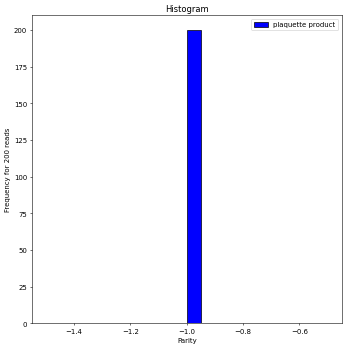

In [89]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for j in qubits_measure:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



# Another version of an even parity encoding - which relies on three 2-chains 

This is also done within one square cell - so that it is compatible with the odd embedding seen above. This is the Leib et al embedding.

In [90]:
edges_chain = [(63,540), (536, 55), (59, 532)]
edges_dominant = [(520, 55), (47, 536), (55, 540), (43, 532), (524, 59), (532, 63)]
edges_intra = [(47, 540), (43,524), (520,47), (520, 63), (43, 540), (524, 63)]

ancilla_sites = [63,540, 536, 55, 59, 532]
qubit_sites = [520, 43, 47, 524]

all_edges = edges_chain + edges_dominant + edges_intra 
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -4
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

all_sites = ancilla_sites + qubit_sites
h_dict = {}
for i in all_sites:
    if i in ancilla_sites:
        h_dict.update({i:-1})
    elif i in qubit_sites:
        h_dict.update({i:-1})

In [91]:
num_reads = 200
response = sampler.sample_ising(h = h_dict, J=J_dict,
                                            num_reads=num_reads,
                                            annealing_time=100,
                                            answer_mode="raw", num_spin_reversal_transforms = 10)

In [92]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=bf7fd61f-24ba-43dd-9297-f12b57dd9b81

'http://127.0.0.1:18000/?problemId=bf7fd61f-24ba-43dd-9297-f12b57dd9b81'

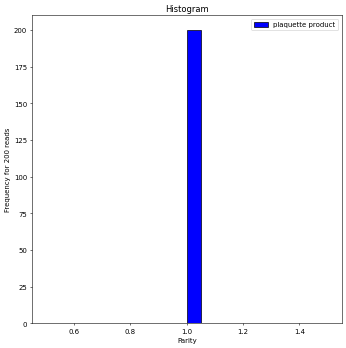

In [93]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
for j in qubit_sites:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



# Stitching it all together:

The challenge then becomes to stich the (even) or (odd) parity encoding next to the other one. For that purpose, a square lattice is divided as a checkerboard lattice with A and B square cells (A and B refer to the S sublattice). Within each of these cells, a P=+1 or -1 cell can sit. We need that cells of (P,S) = (1,A) be compatible with (1, B) and (-1, B), and (-1,A) needs to be compatible with (1,B) and (-1, B). Importantly, (1,S) does not need to be compatible with (-1, S). 

We start by manually creating the embedding for two neighboring unit cells only. Then we need to figure out how to shift these graph units by some lattice vector.